**ATENCIÓN:** Executar la siguiente celda solamente si se esta corriendo este notebook desde Google Colab.

In [ ]:
# this mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'dlvis/assignments/assignment2/'
FOLDERNAME = None
assert FOLDERNAME is not None, "[!] Enter the foldername."

# now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# this downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
!bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME

# Computer Vision CIFAR-10

En este notebook continuaremos profundizando en las funcionalidades de Keras y Tensorflow, para entrenar Redes Neuronales Convolucionales y resolver problemas de clasificación más complejos. En particualr vamos a resolver el problema de clasificación de imágenes en el dataset CIFAR-10.

# Tabla de Contenidos

Este notebook contiene 5 partes. Vamos a repasar algunas funcionalidades básicas de TensorFlow y Keras entrenando un modelo para reconocer dígitos escritos a mano.

1. Parte I, Preparación: cargar dataset CIFAR-10.
2. Parte II, Entendimiento: visualizar datos y obtener algunas estadísticas.
3. Parte III, Entrenamiento: definición y entrenamiento de una Red Convolucional.
4. Parte IV, Evaluación: evaluar el modelo y predecir algunos casos.
4. Parte V, Experimentación

# Parte I: Preparación

Primero, vamos a descargar el dataset CIFAR10. Esto puede tomar algunos minutos para descargar los datos por primer vez, pero luego de que los archivos son descargados y cacheados en disco la carga debería ser más rápida.

Al igual que en el notebook anterior y por simplicidad, vamos a trabajar con el módulo ```tf.keras.datasets``` que ya provee utilidades para cargar y trabajar con este dataset entre otros.

In [1]:
import os
import tensorflow as tf
import numpy as np
import math
import timeit
import matplotlib.pyplot as plt

%matplotlib inline

2022-05-18 15:41:11.286919: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-18 15:41:11.286939: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
def load_cifar10(num_training=48000, num_validation=2000, num_test=10000):
    """
    Fetch the CIFAR-10 dataset from the web and perform preprocessing to prepare
    it for the two-layer neural net classifier.
    """
    # Load the raw CIFAR-10 dataset and use appropriate data types and shapes
    cifar10 = tf.keras.datasets.cifar10.load_data()
    (X_train, y_train), (X_test, y_test) = cifar10
    
    # Subsample the data
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]

    return X_train, y_train, X_val, y_val, X_test, y_test

# If there are errors with SSL downloading involving self-signed certificates,
# it may be that your Python version was recently installed on the current machine.
# See: https://github.com/tensorflow/tensorflow/issues/10779
# To fix, run the command: /Applications/Python\ 3.7/Install\ Certificates.command
#   ...replacing paths as necessary.

# Invoke the above function to get our data.
NHW = (0, 1, 2)
X_train, y_train, X_val, y_val, X_test, y_test = load_cifar10()

Opcionalmente puedes **usasr GPU seteando la siguiente flag en True** en la siguiente celda.

## Usuarios Colab

Si estas usando Colab, seguramente necesites manualmente cambiar a un entorno GPU. La forma de hacer esto es clickeando la opcion `Runtime -> Change runtime type` y seleccionar la opción `GPU` dentro de `Hardware Accelerator`. Notar que debes correr de nuevo todas las celdas de arriba ya que al cambiar de entorno de ejecución el kernel del notebook se reinicia perdiendo el estado actual.

In [3]:
# Set up some global variables
USE_GPU = True

if USE_GPU:
    device = '/device:GPU:0'
else:
    device = '/cpu:0'

# Constant to control how often we print when training models
print_every = 100

print('Using device: ', device)

Using device:  /device:GPU:0


# Parte II: Entendimiento de los datos

Recordemos algunas de las preguntas que nos solemos hacer antes de empezara a trabajar con un set de datos de entrenamiento: 

* ¿Cuántas imágenes tenemos para Train y cuántas para Test?
* ¿Cuántas imágenes tenemos por cada clase, está balanceado?
* ¿Qué resolución tiene cada imagen? ¿Son todas iguales o hay que aplicar algún re-size?
* ¿Cuantos canales tiene la imágen (blanco y negro o a color)?

Además, es una buena práctica visualizar algunas imágenes por cada clase, para comprender bien como son las imágenes con las que estaremos trabajando.

Empecemos entonces a contestar estas preguntas!!

**¿Cuántas imágenes tenemos?**

Veamos algunas estadísticas generales del dataset.

In [4]:
# Print some basic stats about the dataset
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape, y_train.dtype)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (48000, 32, 32, 3)
Train labels shape:  (48000, 1) uint8
Validation data shape:  (2000, 32, 32, 3)
Validation labels shape:  (2000, 1)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000, 1)


**¿Cuántas imágenes tenemos por cada clase?** Complete la celda a continuación par verificar si los datos de entrenamiento (y_train) se encuentran balanceados.

In [18]:
############################################################################
# TODO: Calcular cantidad de ejemplos por clase en y_train y graficar       #
############################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

pass

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
############################################################################
#                            END OF YOUR CODE                              #
############################################################################

**¿Que sucede con el dataset de test?** Complete la celda a continuación para verificar si los datos de prueba (y_test) se encuentran balanceados.

In [ ]:
############################################################################
# TODO: Calcular cantidad de ejemplos por clase en y_test y graficar       #
############################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

pass

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
############################################################################
#                            END OF YOUR CODE                              #
############################################################################

**¿Qué resolución tiene cada imagen?**

El dataset de entrenamiento se compone de **50.000** imágenes de una misma resolución para facilitar el trabajo de entrenamiento. Para corroborar esto se puede revisar las dimensiones de la matrix que contiene los datos de entrenamiento, es decir, las dimensiones de `X_train`. 

_HINT: Recuerde que toda matrix de `numpy` cuenta con el atributo `shape` que describe sus dimensiones._

In [ ]:
############################################################################
# TODO: Revisar la resolución de una imagen de entrenamiento               #
############################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

pass

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
############################################################################
#                            END OF YOUR CODE                              #
############################################################################

**Entendiendo las imágenes**

A continuación vamos a ver de que se tratan las imágenes de CIFAR-10 y para ello vamos a utilizar las misma estrategia que con MNIST: matplotlib. Notese además, a diferencia de MNIST, que en CIFAR-10 las imágenes son a color por lo que tenemos 3 canales extra en las imágenes: RGB.

Por otro lado, en MNIST las imágenes se correspondian a los números 0,1, 2, ... , 9 y sus etiquetas coincidían con el dígito en cuestión. En este caso, las etiquetas son: "airplane", "automobile", ..., "truck". Sin embargo, por simplicidad también se codifican con números del 0 al 9 (en este caso porque tenemos 10 clases). Por ello, será necesario definirnos un diccionario para mapear de los respectivos números en las etiquetas a su clase, para facilitar la interpretación de los resultados.

In [5]:
# Maps label number to class name

idx_to_label = {
    0: "airplane",
    1: "automobile",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck"
}

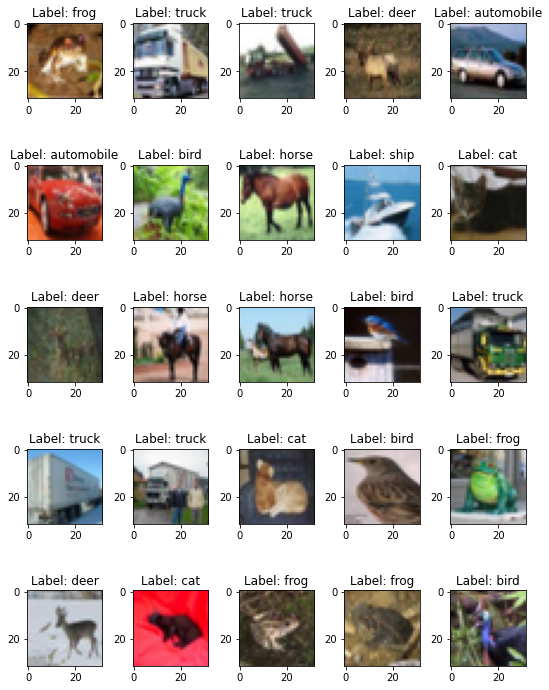

In [6]:
def display_cifar10_images(X, y, num=25, num_row=5, num_col=5):
    """
    Display on a grid using matplotlib train images and their corresponding
    label.
    """
    
    # Get images to display
    images = X[:num]
    labels = y[:num]

    # plot images
    fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
    for i in range(num):
        ax = axes[i//num_col, i%num_col]
        ax.imshow(images[i])
        ax.set_title('Label: {}'.format(idx_to_label[labels[i][0]]))
        
    plt.tight_layout()
    plt.show()

display_cifar10_images(X_train, y_train)

Vamos a ver una forma diferente de normalizar las fotos. Mientras que en el notebook anterior normalizabamos cada pixel de una foto teniendo en cuenta la media y desviación estandard en el dataset, en este caso simplemente vamos a llevar el valor de un pixel al intervalo [0 ... 1]. Esto es porque las Redes Neuronales realizan las operaciones de forma más eficiente con números en este rango.

In [7]:
def scale_images(X_train, X_test):
    """
    This function scales each image to range 0-1 for simplicity for
    neural networks.
    """
    
    ############################################################################
    # TODO: Revisar la resolución de una imagen de entrenamiento               #
    ############################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


    # convert from integers to floats
    train_norm = X_train.astype('float32')
    test_norm = X_test.astype('float32')
    
    # normalize to range 0-1
    train_norm = pass / 255  # TODO: Normalize each pixel in range 0-255
    test_norm = pass / 255  # TODO: Normalize each pixel in range 0-255 
    
    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ############################################################################
    #                            END OF YOUR CODE                              #
    ############################################################################

    return train_norm, test_norm

X_train, X_test = scale_images(X_train, X_test)

# Parte III: Entrenamiento

Ahora que tenemos un mejor entendimiento del problema y las imágenes con las que contamos, pasemos a definir y entrenar el modelo que clasifique las imágenes.

Para esto vamos a utilizar la clase `tf.keras.Sequential` disponible en la libreria Keras, que permite definir una red neuronal con un número arbitrario de `layers`. Por más información acerca de esta clase leer [tf.keras.Sequential](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential) la documentación.

Para entrar en calentamiento lo que vamos a hacer, es definir una sencilla Red Neuronal utilizando convoluciones y finalmente una capa densamente conectada. 

Resumen de la arquitectura:
* Input Layer: Imágenes de 32x32 que como son el input de una convolución no las vamos a aplanar como vector aun. 
* Conv2D: Capa de convolución con 16 filtros de 3x3 y Relu. Leer más en [tf.keras.layers.Conv2D](https://keras.io/api/layers/convolution_layers/convolution2d/).
* Conv2D: Capa de convolución de 32 filtros de 3x3.
* Flatten: Pasamos a vector. Leer más en [tf.keras.layers.Flatten](https://keras.io/api/layers/reshaping_layers/flatten/).
* Hidden Layer: Capa oculta de 64 neuronas con Relu. Leer más sobre [tf.keras.layers.Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense).
* Output Layer: Nuevamente usamos `tf.keras.layers.Dense` pero con largo 10 (por 10 diferentes clases).

In [12]:
# Define model architecture using keras.Sequential API
model = tf.keras.Sequential([
    tf.keras.Input(shape=(32, 32, 3)),
    tf.keras.layers.Conv2D(16, kernel_size=(3, 3), activation="relu"),  # 32 blocks of CONV2D
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),  # 64 blocks of CONV2D
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10)  # Dense of num_classes length
])

Compilación:

In [13]:
# Compile model
model.compile(optimizer='SGD',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [14]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 30, 30, 16)        448       
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 32)        4640      
                                                                 
 flatten_2 (Flatten)         (None, 25088)             0         
                                                                 
 dense_4 (Dense)             (None, 64)                1605696   
                                                                 
 dense_5 (Dense)             (None, 10)                650       
                                                                 
Total params: 1,611,434
Trainable params: 1,611,434
Non-trainable params: 0
_________________________________________________________________


Entrenamiento

In [15]:
# Train model
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
1500/1500 [==============================] - 16s 10ms/step - loss: 1.7804 - accuracy: 0.3684
Epoch 2/10
1500/1500 [==============================] - 16s 10ms/step - loss: 1.4674 - accuracy: 0.4791
Epoch 3/10
1500/1500 [==============================] - 16s 10ms/step - loss: 1.3343 - accuracy: 0.5273
Epoch 4/10
1500/1500 [==============================] - 16s 10ms/step - loss: 1.2177 - accuracy: 0.5682
Epoch 5/10
1500/1500 [==============================] - 16s 10ms/step - loss: 1.1121 - accuracy: 0.6089
Epoch 6/10
1500/1500 [==============================] - 16s 10ms/step - loss: 1.0197 - accuracy: 0.6427
Epoch 7/10
1500/1500 [==============================] - 16s 10ms/step - loss: 0.9348 - accuracy: 0.6724
Epoch 8/10
1500/1500 [==============================] - 16s 10ms/step - loss: 0.8573 - accuracy: 0.7010
Epoch 9/10
1500/1500 [==============================] - 16s 10ms/step - loss: 0.7801 - accuracy: 0.7292
Epoch 10/10
1500/1500 [==============================] - 16s 10m

# Parte IV: Evaluación

A diferencia del MNIST, este es un problema más complejo de resolver por lo que no es de esperar lograr resultados muy buenos con la arquitectura simple definida arriba. De hecho, entrenando esa misma arquitectura, se debería alcanzar una `loss ~ 1.065` y una `accuracy` en el entorno de `0.629` sobre los datos de Test.

In [16]:
test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

print('\nTest accuracy:', test_acc)

313/313 - 1s - loss: 1.1052 - accuracy: 0.6286 - 1s/epoch - 3ms/step

Test accuracy: 0.628600001335144


### Test con imagen arbitraria

Veamos que tan bien nos va con una imagen cualquiera del dataset de Test.

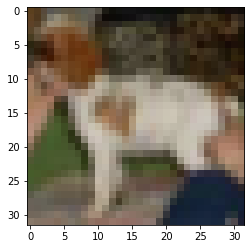

In [130]:
# Change num_sample to test with a different image
num_sample = 12
image = X_test[num_sample]
label = y_test[num_sample]

plt.imshow(image)
plt.show()

In [131]:
predictions = model.predict(np.expand_dims(image, axis=0)) 
prediction = np.argmax(predictions[0])  # prediction is an array of 10 probabilities, the highest is the predicted class

print(f"Prediction: {idx_to_label[prediction]} and expected is: {idx_to_label[label[0]]}")

Prediction: frog and expected is: dog


# Parte IV: Experimentación

Ahora que tenemos claro como definir Redes Neuronales Convolucionales y su poder, te toca el turno a ti de jugar con diferentes opciones de arquitecturas para alcanzar una mejor accuracy sobre los datos de Test.

A modo de guia te sugerimos algunas de las siguientes variantes para probar:

* Agregar layers de convolución: Agregar más capas Conv2D y con mayor profundidad (32, 64, 128).
* Probar intercalar layers de convolución con Max Pooling.  Leer más en [tf.keras.layers.MaxPooling2D](https://keras.io/api/layers/pooling_layers/max_pooling2d/).
* Probar varias layers densas al final para incrementar capacidad del modelo.
* Optimizadores: En el modelo original se utiliza SGD (Stochastic gradient descent), probar con otros optimizadores como [RMSprop o Adam](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers).
* Dropout: 

* Dropout: Para evitar sobreajuste. Leer más en [tf.keras.layers.Dropout](https://keras.io/api/layers/regularization_layers/dropout/).


In [ ]:
############################################################################
# TODO: Calcular cantidad de ejemplos por clase en y_test y graficar       #
############################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

model = tf.keras.Sequential([
    ...  # TODO: Edit this
])

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
############################################################################
#                            END OF YOUR CODE                              #
############################################################################

In [ ]:
model.summary()

In [ ]:
############################################################################
# TODO: Calcular cantidad de ejemplos por clase en y_test y graficar       #
############################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

model.compile(optimizer=pass,  # TODO: Select an optimizer
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
############################################################################
#                            END OF YOUR CODE                              #
############################################################################

In [ ]:
############################################################################
# TODO: Calcular cantidad de ejemplos por clase en y_test y graficar       #
############################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

model.fit(X_train, y_train, epochs=pass)  # TODO: select num of epochs

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
############################################################################
#                            END OF YOUR CODE                              #
############################################################################

In [ ]:
test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

print('\nTest accuracy:', test_acc)